<a href="https://colab.research.google.com/github/gvanhemert/aerosols-deep-learning/blob/main/Models/model_3days_aerosols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# builtins
import locale
import math
import glob
import pathlib
import functools
import logging
import time
import datetime

# numerical stuff
#import pickle5 as pickle
import tables

import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
#from tensorflow.python import ipu

#import libpvti as pvti

# plotting
# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

logging.basicConfig(level=logging.INFO)


In [3]:
data_path_train = '/content/drive/MyDrive/Master Thesis/Data/train_001_3days'
data_path_test = '/content/drive/MyDrive/Master Thesis/Data/test_NAT_3days'
#meta_data_path = '/mnt/poddata/data/bathy-emodnet-a-runs.h5'
#all_checkpoints_path = 'gs://bathy_sample/dnn/checkpoints'
all_checkpoints_path = '/content/drive/MyDrive/Master Thesis/Checkpoints'
model_name = 'simple-cnn-unet-v0.1'
model_path = '/content/drive/MyDrive/Master Thesis/Data/models'
checkpoints_path = all_checkpoints_path + '/' + model_name

learning_rate = 1e-4
n_epochs = 200
batch_size = 8
steps_per_execution = 1
raster_shape = (96, 192, 1)

In [4]:
def tf_parse(eg):
    """parse an example (or batch of examples, not quite sure...)"""

    # here we re-specify our format
    # you can also infer the format from the data using tf.train.Example.FromString
    # but that did not work
    example = tf.io.parse_example(
        eg[tf.newaxis],
        {
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'day': tf.io.FixedLenFeature([], tf.int64),
            'spex_day': tf.io.FixedLenFeature([], tf.string),
            'ctl_lat_grad': tf.io.FixedLenFeature([], tf.string),
            'ctl_lon_grad': tf.io.FixedLenFeature([], tf.string),
            'ctl_day': tf.io.FixedLenFeature([], tf.string),
            'nat_day': tf.io.FixedLenFeature([], tf.string),
        },
    )
    day = example["day"]

    spex_day = tf.io.parse_tensor(example["spex_day"][0], out_type="float32")

    ctl_lat_grad = tf.io.parse_tensor(example["ctl_lat_grad"][0], out_type="float32")
    ctl_lat_grad = (ctl_lat_grad - tf.math.reduce_mean(ctl_lat_grad)) / (tf.math.reduce_max(ctl_lat_grad) - tf.math.reduce_min(ctl_lat_grad))

    ctl_lon_grad = tf.io.parse_tensor(example["ctl_lon_grad"][0], out_type="float32")
    ctl_lon_grad = (ctl_lon_grad - tf.math.reduce_mean(ctl_lon_grad)) / (tf.math.reduce_max(ctl_lon_grad) - tf.math.reduce_min(ctl_lon_grad))

    ctl_day = tf.io.parse_tensor(example["ctl_day"][0], out_type="float32")
    ctl_day = (ctl_day - tf.math.reduce_mean(ctl_day)) / (tf.math.reduce_max(ctl_day) - tf.math.reduce_min(ctl_day))

    nat_day = tf.io.parse_tensor(example["nat_day"][0], out_type="float32")
    nat_day = tf.math.log(nat_day)
    
    input_data_1 = tf.concat([ctl_lat_grad, ctl_lon_grad, ctl_day], axis=-1)
    input_data_2 = spex_day
    return (input_data_1, input_data_2), nat_day

In [5]:
def tf_parse_plot(eg):
    """parse an example (or batch of examples, not quite sure...)"""

    # here we re-specify our format
    # you can also infer the format from the data using tf.train.Example.FromString
    # but that did not work
    example = tf.io.parse_example(
        eg[tf.newaxis],
        {
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'day': tf.io.FixedLenFeature([], tf.int64),
            'spex_day': tf.io.FixedLenFeature([], tf.string),
            'ctl_lat_grad': tf.io.FixedLenFeature([], tf.string),
            'ctl_lon_grad': tf.io.FixedLenFeature([], tf.string),
            'ctl_day': tf.io.FixedLenFeature([], tf.string),
            'nat_day': tf.io.FixedLenFeature([], tf.string),
        },
    )
    day = example['day']

    spex_day = tf.io.parse_tensor(example["spex_day"][0], out_type="float32")

    ctl_lat_grad = tf.io.parse_tensor(example["ctl_lat_grad"][0], out_type="float32")

    ctl_lon_grad = tf.io.parse_tensor(example["ctl_lon_grad"][0], out_type="float32")

    ctl_day = tf.io.parse_tensor(example["ctl_day"][0], out_type="float32")

    nat_day = tf.io.parse_tensor(example["nat_day"][0], out_type="float32")
    
    input_data_1 = tf.concat([ctl_lat_grad, ctl_lon_grad, ctl_day], axis=-1)
    input_data_2 = spex_day
    return (input_data_1, input_data_2), nat_day

In [6]:
def get_files(data_path):
    files = tf.io.gfile.glob(data_path + "/" + "*.tfrecords")
    return files

def get_dataset(files):
    """return a tfrecord dataset with all tfrecord files"""
    dataset =  tf.data.TFRecordDataset(files)
    dataset = dataset.map(tf_parse)
    return dataset

def get_plot_dataset(files):
    """return a tfrecord dataset with all tfrecord files"""
    dataset =  tf.data.TFRecordDataset(files)
    dataset = dataset.map(tf_parse_plot)
    return dataset

In [7]:
def full_model(input_shape_1, input_shape_2):
    
    model_input_1 = Input(input_shape_1)
    x = Conv2D(4, (3,3), padding="same")(model_input_1)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x1 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x1)

    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    encoder_output_1 = BatchNormalization()(x)

    # 2nd input

    model_input_2 = Input(input_shape_2)
    x = Conv2D(4, (3,3), padding="same")(model_input_2)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x2 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x2)

    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    encoder_output_2 = BatchNormalization()(x)

    encoder_output = tf.keras.layers.add([encoder_output_1, encoder_output_2])
    

    #################################### Decoder
    
    x = Conv2DTranspose(128, (3,3), padding="same")(encoder_output)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x) 

    x = Conv2DTranspose(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = tf.keras.layers.concatenate([x, x1, x2])
    x = Conv2DTranspose(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
  
    x = Conv2DTranspose(4, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    model_output = Conv2DTranspose(1, (3,3), padding="same", activation="linear")(x)
  
    model = Model(inputs=[model_input_1, model_input_2], outputs = model_output)
    
    return model



In [8]:
train_files = get_files(data_path_train)
test_files = get_files(data_path_test)

train_dataset = get_dataset(train_files)
test_dataset = get_dataset(test_files)

train_dataset = train_dataset.shuffle(365*batch_size).batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.shuffle(365*batch_size).batch(batch_size, drop_remainder=True)

plot_train = get_plot_dataset(train_files).batch(batch_size, drop_remainder=True)
plot_test = get_plot_dataset(test_files).batch(batch_size, drop_remainder=True)

In [9]:
#for sample in train_dataset.take(1):
  #print(repr(sample))

In [10]:
model = full_model((96, 192, 3), (96, 192, 3))
opt = Adam(learning_rate=learning_rate, decay=learning_rate / n_epochs)

model.compile(loss="mean_absolute_error", optimizer=opt, steps_per_execution=steps_per_execution)

callbacks = [
tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path, 
    save_weights_only=True,
    #monitor='val_mse',
    mode='max',
    save_best_only=True
),
tf.keras.callbacks.CSVLogger(
    filename=checkpoints_path + '.csv')
]

model.fit(x=train_dataset, validation_data=test_dataset, epochs=n_epochs, callbacks=callbacks)#, steps_per_epoch=steps_per_epoch)
model.save(model_path + '/' + model_name + '.h5')


Epoch 1/200
45/45 [==============================] - 39s 469ms/step - loss: 3.0367 - val_loss: 2.8796
Epoch 2/200
45/45 [==============================] - 15s 314ms/step - loss: 2.9761 - val_loss: 2.7798
Epoch 3/200
45/45 [==============================] - 15s 313ms/step - loss: 2.9546 - val_loss: 2.7639
Epoch 4/200
45/45 [==============================] - 15s 316ms/step - loss: 2.9301 - val_loss: 2.8131
Epoch 5/200
45/45 [==============================] - 15s 314ms/step - loss: 2.9046 - val_loss: 2.7544
Epoch 6/200
45/45 [==============================] - 15s 313ms/step - loss: 2.8738 - val_loss: 2.7124
Epoch 7/200
45/45 [==============================] - 15s 315ms/step - loss: 2.8432 - val_loss: 2.6137
Epoch 8/200
45/45 [==============================] - 15s 314ms/step - loss: 2.8091 - val_loss: 2.4642
Epoch 9/200
45/45 [==============================] - 15s 314ms/step - loss: 2.7730 - val_loss: 2.3474
Epoch 10/200
45/45 [==============================] - 15s 314ms/step - loss: 2.732

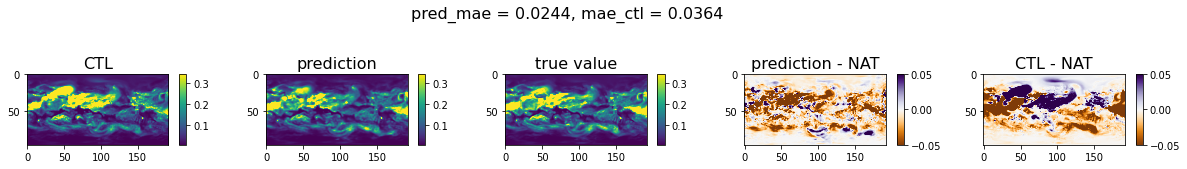

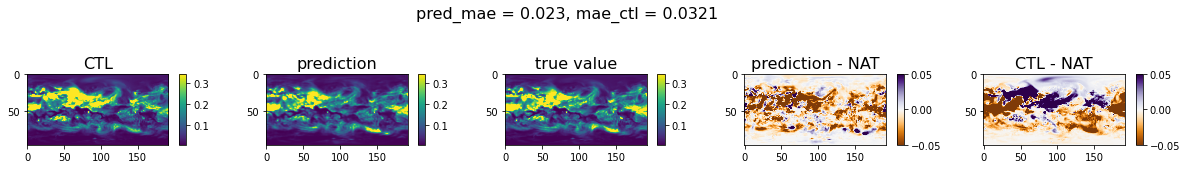

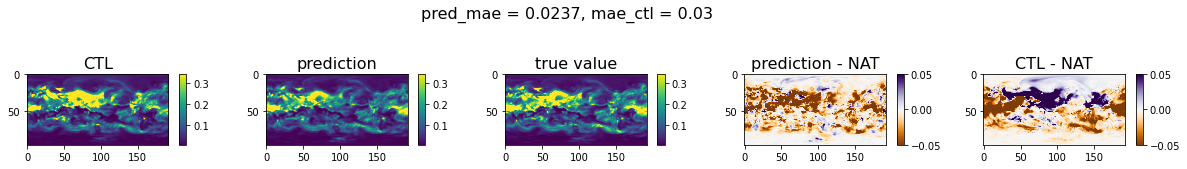

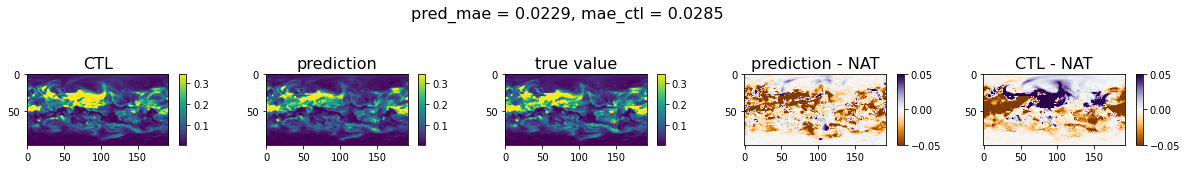

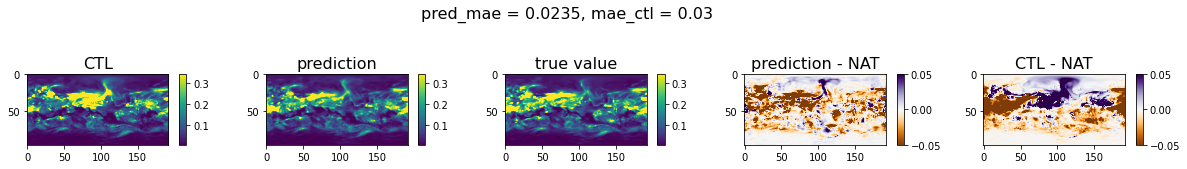

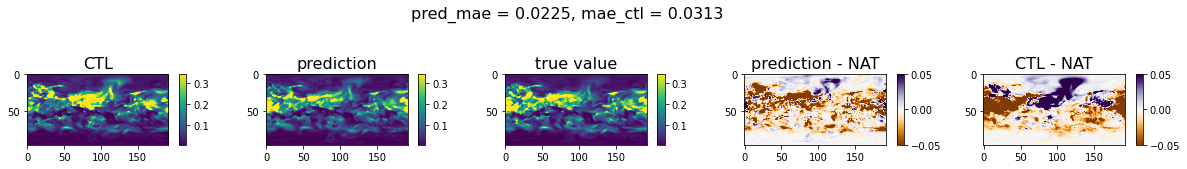

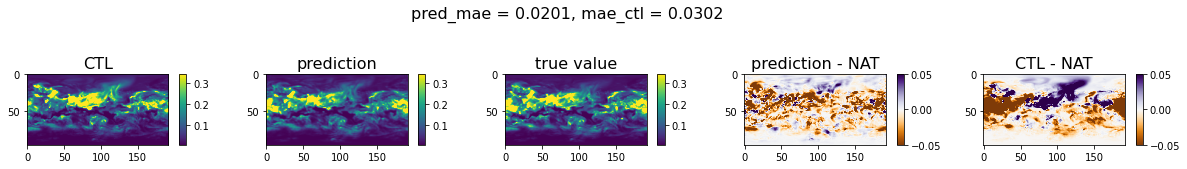

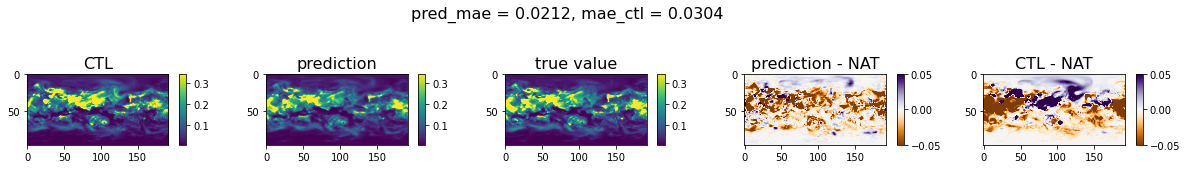

In [18]:
#model = load_model(model_path + '/' + model_name + '.h5')
train_dataset = get_dataset(train_files)
test_dataset = get_dataset(test_files)

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
index = 0
skip_count = 5
for sample in test_dataset.skip(skip_count).take(1):
    for plot_sample in plot_test.skip(skip_count).take(1):
        (input, output) = sample
        (plot_input, plot_output) = plot_sample
        for index in range(8):
            prediction = model.predict(input)[index][...,0]
            prediction = np.exp(prediction)
            spex_one = input[1][index,...,1]
            ctl = plot_input[0][index,...,-1]
            true_value = plot_output[index,...,0] 
            (vmin, vmax) = np.percentile(plot_output, [5, 95])

            fig, axes = plt.subplots(figsize=(20,3), ncols=5)
            plt.subplots_adjust(wspace=0.5)
            #fig.suptitle(f'rmse = {np.sqrt(tf.reduce_mean((true_value - prediction)**2)):.3}, rmse_ctl = {np.sqrt(tf.reduce_mean((ctl - prediction)**2)):.3}', fontsize=16)
            #fig.suptitle(f'me = {tf.reduce_mean(true_value - prediction):.3}, me_ctl = {tf.reduce_mean(true_value - ctl):.3}', fontsize=16)
            fig.suptitle(f'pred_mae = {tf.reduce_mean(tf.math.abs(prediction - true_value)):.3}, mae_ctl = {tf.reduce_mean(tf.math.abs(ctl - true_value)):.3}', fontsize=16)

            axes[0].set_title('CTL', fontsize=16)
            im = axes[0].imshow(ctl, vmin=vmin, vmax=vmax)
            divider = make_axes_locatable(axes[0])
            cax = divider.append_axes("right", size="5%", pad=0.15)
            plt.colorbar(im, cax=cax)

            axes[1].set_title('prediction', fontsize=16)
            im = axes[1].imshow(prediction, vmin=vmin, vmax=vmax)
            divider = make_axes_locatable(axes[1])
            cax = divider.append_axes("right", size="5%", pad=0.15)
            plt.colorbar(im, cax=cax)
            
            axes[2].set_title('true value', fontsize=16)
            im = axes[2].imshow(true_value, vmin=vmin, vmax=vmax)
            divider = make_axes_locatable(axes[2])
            cax = divider.append_axes("right", size="5%", pad=0.15)
            plt.colorbar(im, cax=cax)

            axes[3].set_title('prediction - NAT', fontsize=16)
            im = axes[3].imshow(prediction - true_value, cmap='PuOr', vmin=-0.05, vmax=0.05)
            divider = make_axes_locatable(axes[3])
            cax = divider.append_axes("right", size="5%", pad=0.15)
            plt.colorbar(im, cax=cax)

            axes[4].set_title('CTL - NAT', fontsize=16)
            im = axes[4].imshow(ctl - true_value, cmap='PuOr', vmin=-0.05, vmax=0.05)
            divider = make_axes_locatable(axes[4])
            cax = divider.append_axes("right", size="5%", pad=0.15)
            plt.colorbar(im, cax=cax)


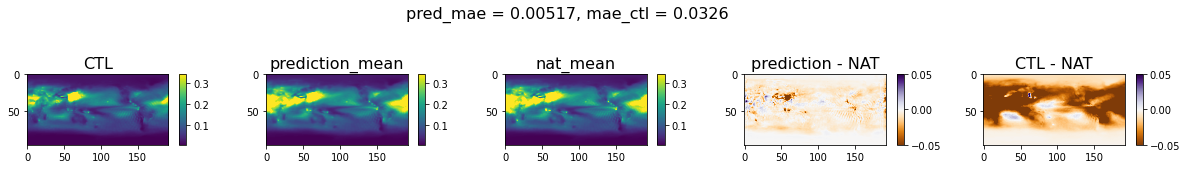

In [12]:
#model = load_model(model_path + '/' + model_name + '.h5')
prediction_mean = tf.reduce_mean(tf.math.exp(model.predict(test_dataset)), axis=0)[...,0]
#prediction_mean = tf.math.exp(test_mean)
ctl_mean = np.zeros((96, 192))
nat_mean = np.zeros((96, 192))
s = 0
for element in plot_test.as_numpy_iterator(): 
    ctl_mean += np.sum(element[0][0][...,-1], axis=0)
    nat_mean += np.sum(element[1][...,0], axis=0)
    s += 1
ctl_mean = ctl_mean / (s*8.)
nat_mean = nat_mean / (s*8.)

(vmin, vmax) = np.percentile(nat_mean, [5, 95])

fig, axes = plt.subplots(figsize=(20,3), ncols=5)
plt.subplots_adjust(wspace=0.5)
#fig.suptitle(f'rmse = {np.sqrt(tf.reduce_mean((nat_mean - prediction_mean)**2)):.3}, rmse_ctl = {np.sqrt(tf.reduce_mean((ctl_mean - prediction_mean)**2)):.3}', fontsize=16)
#fig.suptitle(f'me = {tf.reduce_mean(prediction_mean - nat_mean):.3}, me_ctl = {tf.reduce_mean(ctl_mean - nat_mean):.3}', fontsize=16)
fig.suptitle(f'pred_mae = {tf.reduce_mean(tf.math.abs(prediction_mean - nat_mean)):.3}, mae_ctl = {tf.reduce_mean(tf.math.abs(ctl_mean - nat_mean)):.3}', fontsize=16)

axes[0].set_title('CTL', fontsize=16)
im = axes[0].imshow(ctl_mean, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

axes[1].set_title('prediction_mean', fontsize=16)
im = axes[1].imshow(prediction_mean, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

axes[2].set_title('nat_mean', fontsize=16)
im = axes[2].imshow(nat_mean, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

axes[3].set_title('prediction - NAT', fontsize=16)
im = axes[3].imshow(prediction_mean - nat_mean, cmap='PuOr', vmin=-0.05, vmax=0.05)
divider = make_axes_locatable(axes[3])
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

axes[4].set_title('CTL - NAT', fontsize=16)
im = axes[4].imshow(ctl_mean - nat_mean, cmap='PuOr', vmin=-0.05, vmax=0.05)
divider = make_axes_locatable(axes[4])
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)

In [19]:
history = pd.read_csv(all_checkpoints_path + '/' + model_name + '.csv')

plt.title('Training progression')
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')

'simple-cnn-unet-v0.1'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 192, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 96, 192, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 192, 4)   112         ['input_1[0][0]']                
                                                                                              

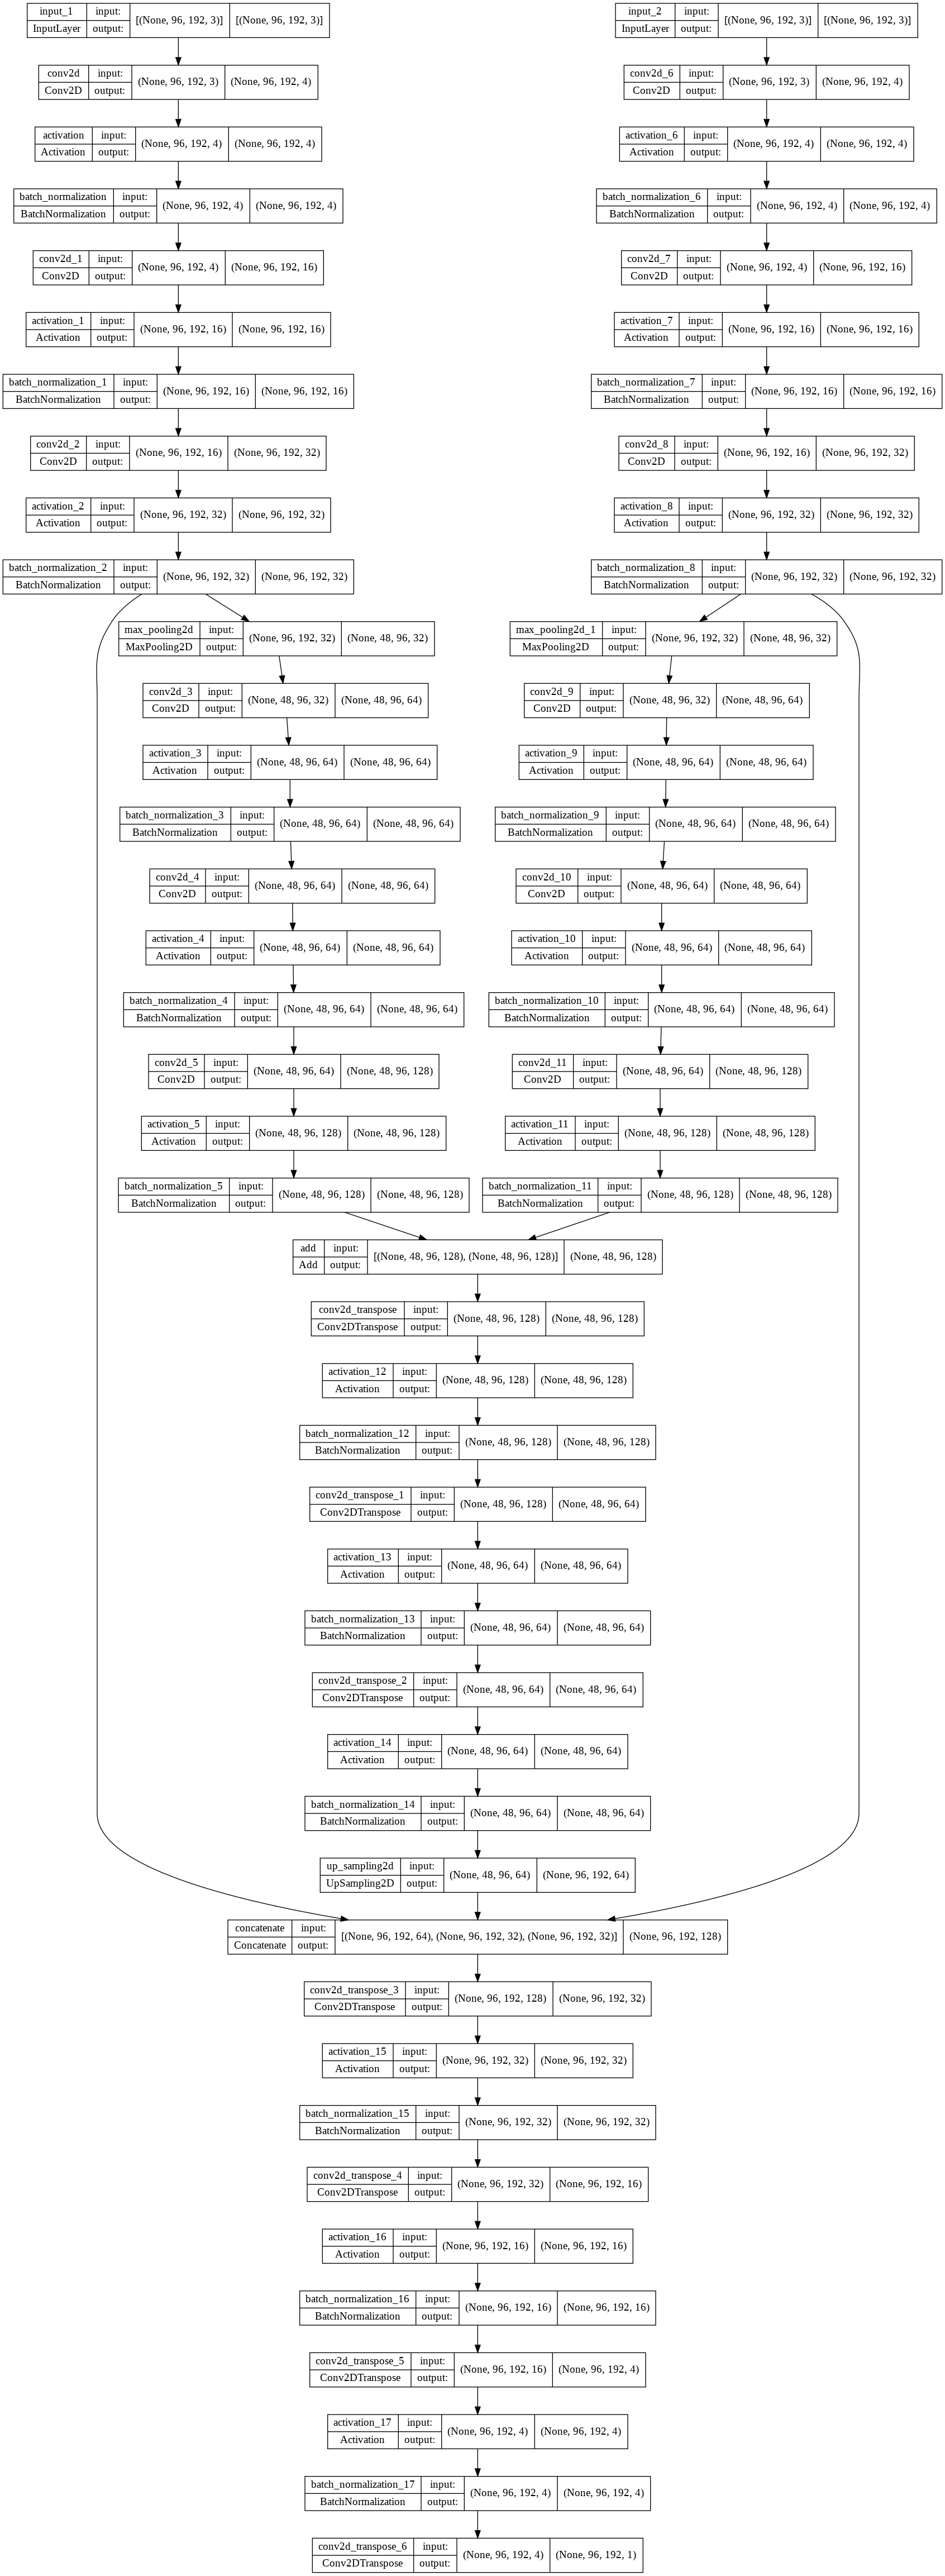

In [8]:
model.summary()
model.count_params()
tf.keras.utils.plot_model(model, show_shapes=True)